In [5]:
import os
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time
import sys
import numpy as np
import pandas as pd
import random
import http.client

# Picking up where SQL left off - Cleaning BV Data in Pandas
Read in the raw data to a dataframe from a csv

In [50]:
# Currently 
bv_data = pd.read_csv('bv_property_features.csv')
bv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86713 entries, 0 to 86712
Data columns (total 10 columns):
property_id        86713 non-null int64
roof_data_date     86713 non-null object
street             85615 non-null object
city               85543 non-null object
state              85626 non-null object
zip                85538 non-null object
full_address       85621 non-null object
visual_score       86712 non-null float64
detection_types    86713 non-null object
detections         86713 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 6.6+ MB


Clean data by dropping rows with duplicate addresses. The oldest record is being kept to give us the best chance of obtaining a relevant sale record.

In [53]:
bv_data.sort_values('roof_data_date', ascending = True, inplace = True)
bv_data.drop_duplicates(subset = 'full_address', keep = 'first', inplace = True)
bv_data.reset_index(inplace = True, drop = True)
bv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72852 entries, 0 to 72851
Data columns (total 10 columns):
property_id        72852 non-null int64
roof_data_date     72852 non-null object
street             72842 non-null object
city               72777 non-null object
state              72851 non-null object
zip                72780 non-null object
full_address       72851 non-null object
visual_score       72851 non-null float64
detection_types    72852 non-null object
detections         72852 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 5.6+ MB


Still have some empty cells, so dropping rows with missing address data. If we don't have working address data, we can't retrieve the key feature and target data for the property.

In [55]:
bv_data.dropna(axis=0, how='any', inplace=True)
bv_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72698 entries, 0 to 72851
Data columns (total 10 columns):
property_id        72698 non-null int64
roof_data_date     72698 non-null object
street             72698 non-null object
city               72698 non-null object
state              72698 non-null object
zip                72698 non-null object
full_address       72698 non-null object
visual_score       72698 non-null float64
detection_types    72698 non-null object
detections         72698 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 6.1+ MB


Additional unpacking and cleaning of the roof condition labels will be needed; however, that is being skipped at this time while other aspects of the project are explored to assess viability.

In [57]:
print('The Visual Score for these properties is distributed as follows:')
bv_data.visual_score.describe()

The Visual Score for these properties is distributed as follows:


count    72698.000000
mean        82.138920
std         20.244598
min          0.045324
25%         71.877930
50%         89.584066
75%         98.376623
max         99.715704
Name: visual_score, dtype: float64

Text(0.5,1,'Visual Score Histogram')

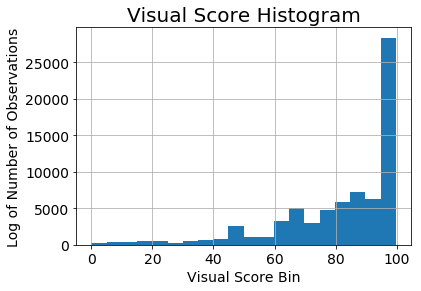

In [58]:
ax = bv_data.visual_score.hist(bins = 20, xlabelsize = 14, ylabelsize = 14)
ax.set_xlabel('Visual Score Bin', fontsize = 14)
ax.set_ylabel('Log of Number of Observations', fontsize = 14)
ax.set_title('Visual Score Histogram', fontsize = 20)

Text(0.5,1,'Visual Score Histogram with Log Scale')

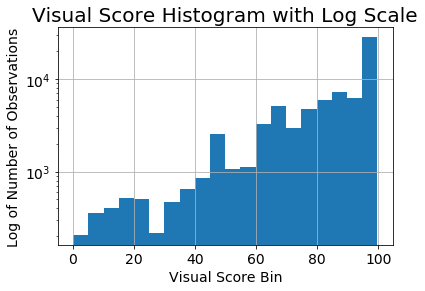

In [59]:
ax = bv_data.visual_score.hist(bins = 20, log = True, xlabelsize = 14, ylabelsize = 14)
ax.set_xlabel('Visual Score Bin', fontsize = 14)
ax.set_ylabel('Log of Number of Observations', fontsize = 14)
ax.set_title('Visual Score Histogram with Log Scale', fontsize = 20)

In [66]:
# Take a small sample for testing
bv_data_test = bv_data.iloc[:10, :]

## Scalable Scraping of Real Estate Page for Historical Estimate Data
We start proving our concept by providing a short list of properties for our script to scrape:

First we must set up our web driver so that we can automate the navigation and data entry  for our scraping script.

In [62]:
chromedriver = "/Users/tylerpreston/bin/chromedriver"  # path to the chromedriver executable
chromedriver = os.path.expanduser(chromedriver)
sys.path.append(chromedriver)
driver = webdriver.Chrome(chromedriver)

Then tell it where to go

In [63]:
url = 'https://realtor.com'
driver.get(url)

Find the element that we are interested in

In [65]:
element = driver.find_element_by_id('rdc-main-search-nav-hero-input')

Type the first address from our test sample. Include short, exponentially distributed delays between key strokes to seem more human.

In [67]:
search_string = bv_data_test.full_address[0].lower()

In [68]:
for letter in search_string:
    element.send_keys(letter)
    time.sleep(np.random.exponential() * .12)
element.send_keys(Keys.RETURN)

Pull page_source data with Beautiful Soup and save all scripts (there are a lot of scripts and the one we are interested in may not show up right away)

In [69]:
soup = BeautifulSoup(driver.page_source, 'html.parser')
scripts = soup.find_all("script")

Scripts are not organized/structured, so we manually search them for the desired data

In [70]:
estimate_dictionary = {}
for script in scripts:
    script = str(script)
    if 'avm_trend' in script:
        index = script.find('avm_trend')
        script = script[index: len(script)]
        start_index = script.find('{')
        stop_index = script.find('}') + 1
        estimate_dictionary[search_string] = json.loads(script[start_index:stop_index])['history']

Navigate back to the home page. This isn't actually working in my Python script. Not sure why. But just telling it get realtor.com works.

In [80]:
driver.back()

Find the search input bar again, but this time we need to clear the text from our previous address.

In [76]:
element = driver.find_element_by_id('rdc-main-search-nav-hero-input')
element.clear()

Do it again with the next address, and so on

In [77]:
search_string = bv_data_test.full_address[1].lower()

for letter in search_string:
    element.send_keys(letter)
    time.sleep(np.random.exponential() * .2)
time.sleep(np.random.exponential() * .6)
element.send_keys(Keys.RETURN)

Check out the end product if you want

In [ ]:
estimate_dictionary

Close the driver when finished

In [81]:
driver.close()

# Attom API for Easy Sales History

In [293]:
def get_property_detail(street, city, state, postal, key):
    address1 = ('%20').join(street.split())
    address2 = ('%20').join([city, state, postal])
    end_url = '/propertyapi/v1.0.0/property/detail?address1='\
        + address1 + "&address2=" + address2

    conn.request("GET", end_url, headers=headers)

    res = conn.getresponse()
    data = json.loads(res.read().decode('utf-8'))
    return data


def get_sales_history_by_address(street, city, state, postal, key):
    address1 = ('%20').join(street.split())
    address2 = ('%20').join((city + ' ' + state + ' ' + postal).split())
    end_url = '/propertyapi/v1.0.0/saleshistory/detail?address1='\
        + address1 + "&address2=" + address2

    conn.request("GET", end_url, headers=headers)

    res = conn.getresponse()
    sales_data = json.loads(res.read().decode('utf-8'))
    
    if sales_data['status']['code'] == 0:
        sales_data = sales_data['property'][0]['salehistory']
    else:
        sales_data = []
    return sales_data


def get_relevant_sale(sales_data, date):
    for sale in sales_data:
        try:
            sale_date = date_to_epoch(sale['amount']['salerecdate'])
        except:
            try:
                sale_date = date_to_epoch(sale['saleTransDate'])
            except:
                continue
        sale_amount = sale['amount']['saleamt']
        if sale_date > date and sale_amount > 0:
            return (sale_date, sale_amount)
    return ('null', 'null')

def date_to_epoch(date):
    if len(date) < 11:
        pattern = '%Y-%m-%d'
    else:
        date = date[0:10]
        pattern = '%Y-%m-%d'
    return int(time.mktime(time.strptime(date, pattern)))

def append_portfolio_sales_history(df):
    # Set up connection to the Attom API
    conn = http.client.HTTPSConnection("search.onboard-apis.com")

    headers = {
        'accept': "application/json",
        'apikey': key
    }
    
    # Iterate through rows of Betterview data to append relevant sales data
    relevant_sale_dates = []
    relevant_sale_amounts = []
    for label, row in df.iterrows():
        street, city, state, postal = row.street, row.city, row.state, row.zip
        date = date_to_epoch(row.roof_data_date)
        sales_data = get_sales_history_by_address(street, city, state, postal, key)
        relevant_sale = get_relevant_sale(sales_data, date)
        relevant_sale_dates.append(relevant_sale[0])
        relevant_sale_amounts.append(relevant_sale[1])
        time.sleep(.2)
   
    conn.close()    
        
    df['relevant_sale_date'] = pd.Series(relevant_sale_dates)
    df['relevant_sale_amount'] = pd.Series(relevant_sale_amounts)
    return df


In [174]:
# Obtain Attom API key from secure location
with open("/Users/tylerpreston/bin/config/attom_key.conf", 'r') as f:
    key = f.readline().strip()

In [246]:
# Execute everything above:
results = append_portfolio_sales_history(bv_data_test)
results.head()